# Objective

In this notebook we are showcasing a model that can predict the review given to an anime by the general public.

After that we are going to fine tune the model on a specific user to try and learn its preferences.

In [1]:
import torch as t
import random
import numpy as np

device = "cuda" if t.cuda.is_available() else "cpu"
print(f"using device: {device}")

# Reproducibility -> Also ensures same train / validation / test split every time
t.manual_seed(0)
random.seed(0)
np.random.seed(0)

using device: cuda


# Dataset

After preprocessing (done with knime) we now have a csv file containing the data

The result is a dataset that has splits data like so: User, Anime Information, Genre, Rating


In [2]:
from pandas import read_csv
from torch.utils.data import Dataset
from tqdm import tqdm


class AnimeReviewsDataset(Dataset):
    def __init__(self, path) -> None:
        print(f"Reading csv from: {path}")
        df = read_csv(path)
        self.ratings = df["rating"].to_list()
        self.users = df["user_id"].to_list()
        self.genres = df["Genres"].to_list()

        df = df.drop(columns=["rating", "user_id", "Genres"])
        self.anime_features = df
        self.PADDING_VALUE = 0

        print(f"Handling Genres")
        s = set()
        for genre in tqdm(self.genres):
            genres = genre.split(",")
            s = s.union(set(genres))
        s = list(s)
        self.unique_genres = len(s)
        s = { g:i + 1 for i, g in enumerate(s)}

        print(f"Tokenizing genres")
        for i in tqdm(range(len(self.genres))):
            g = self.genres[i].split(",")
            g = [s[gen] for gen in g]
            self.genres[i] = g


        self.max_genre_len = max([len(a) for a in self.genres])


    def __len__(self):
        return len(self.users)

    def __getitem__(self, index):
        user = t.Tensor([self.users[index]])
        anime_features = t.Tensor(self.anime_features.iloc[[index]].to_numpy().tolist())
        genres = t.Tensor(self.genres[index]).long()
        rating = t.Tensor([self.ratings[index]]).long()

        L = genres.shape[0]
        genres = t.nn.functional.pad(genres, (0, self.max_genre_len - L), value=self.PADDING_VALUE)
        return user, anime_features, genres, rating


dataset = AnimeReviewsDataset("/home/andreacacioli/Documents/github/MachineLearning/Projects/Anime Recommender System (Knime)/data/preprocessed_anime_reviews.csv")
print(dataset.__getitem__(155))
print(dataset.anime_features.iloc[[120]])
print("Values of type:")
print(dataset.anime_features["Type"].unique())
types = len(dataset.anime_features["Type"].unique())
print(f"types = {types}")
print(f"unique genres = {dataset.unique_genres}")

Reading csv from: /home/andreacacioli/Documents/github/MachineLearning/Projects/Anime Recommender System (Knime)/data/preprocessed_anime_reviews.csv
Handling Genres


100%|██████████| 56534590/56534590 [00:42<00:00, 1321535.64it/s]


Tokenizing genres


100%|██████████| 56534590/56534590 [00:58<00:00, 964827.94it/s] 


(tensor([2.]), tensor([[  8.2900,   2.0000,  24.0000,   7.0000, 230.0000,  51.0000]]), tensor([15, 66, 19,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]), tensor([9]))
     Score  Type  Episodes  Studios  Ranked  Popularity
120   6.59     2        26       42    5447        2645
Values of type:
[0 1 2 3 4 5]
types = 6
unique genres = 79


# Data distribution visualization

We now plot the data to see how the ratings are distributed

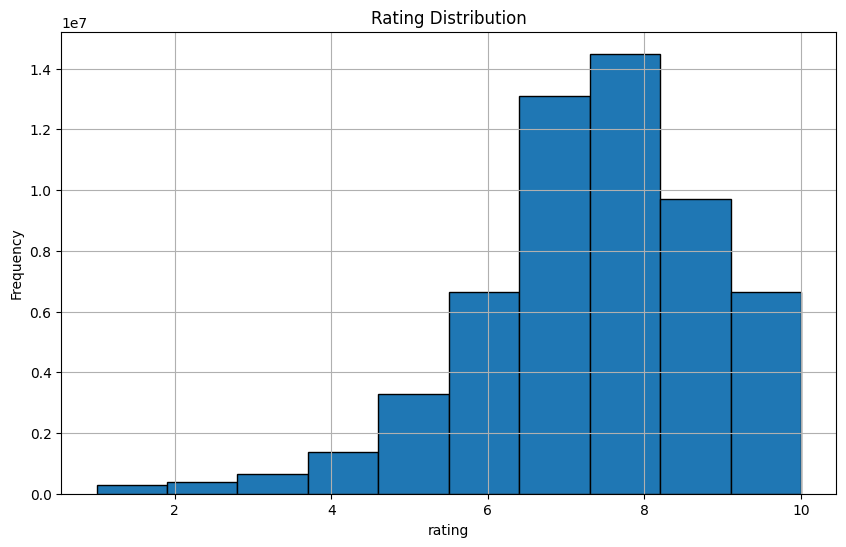

In [3]:
import matplotlib.pyplot as plt


x = dataset.ratings
plt.figure(figsize=(10,6))
plt.hist(x, bins=10, edgecolor='black') 
plt.title("Rating Distribution") 
plt.xlabel("rating") 
plt.ylabel("Frequency") 
plt.grid(True) 

# Separate the dataset

We split the dataset into training, test and validation

In [4]:
from torch.utils.data import random_split, DataLoader

batch_size = 2048

train_dataset, test_dataset, validation_dataset = random_split(dataset, [0.8, 0.1, 0.1])

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)
validation_dataloader = DataLoader(
    validation_dataset, shuffle=True, batch_size=batch_size
)

# Define a generic step

We perform this step regardless of the model, optimizer, or the phase we are in (training / test)

In [5]:
def run_step(model, loss_fn, features, genres, target):
    features = features.squeeze().to(device)
    target = target.squeeze().long().to(device)
    ones = t.ones(target.shape).long().to(device)
    target = t.sub(target, ones) # To go from ratings in [1:10] to values in [0:9]
    x = model(features, genres)
    loss = loss_fn(x, target)
    return loss, x

# The Model

Now it is time to build the model that predicts the value of a rating given the features

In [6]:
class MLP_Predictor(t.nn.Module):
    def __init__(self, types, emb_size, device, genres, ratings = 10, hidden_size = 4096) -> None:
        super().__init__()
        self.device = device
        self.embed = t.nn.Embedding(types, emb_size).to(device)
        self.genre_embedder = t.nn.Embedding(genres + 1, emb_size, padding_idx=dataset.PADDING_VALUE).to(device)
        self.sequential = t.nn.Sequential(
            # We expect 5 features + the type
            t.nn.LayerNorm(5 + emb_size * 2),
            t.nn.Linear(5 + emb_size * 2, hidden_size // 4),
            t.nn.ReLU(),
            t.nn.LayerNorm(hidden_size // 4),
            t.nn.Dropout(0.2),
            t.nn.Linear(hidden_size // 4, hidden_size // 2),
            t.nn.ReLU(),
            t.nn.LayerNorm(hidden_size // 2),
            t.nn.Dropout(0.2),
            t.nn.Linear(hidden_size // 2, hidden_size),
            t.nn.ReLU(),
            t.nn.LayerNorm(hidden_size),
            t.nn.Linear(hidden_size, hidden_size),
            t.nn.ReLU(),
            t.nn.LayerNorm(hidden_size),
            t.nn.Dropout(0.2),
            t.nn.Linear(hidden_size, hidden_size),
            t.nn.ReLU(),
            t.nn.LayerNorm(hidden_size),
            t.nn.Dropout(0.2),
            t.nn.Linear(hidden_size, hidden_size),
            t.nn.ReLU(),
            t.nn.Dropout(0.2),
            t.nn.Linear(hidden_size, hidden_size),
            t.nn.LayerNorm(hidden_size),
            t.nn.ReLU(),
            t.nn.Dropout(0.2),
            t.nn.BatchNorm1d(hidden_size),
            t.nn.Linear(hidden_size, ratings),
        ).to(device)


    def forward(self, x, genres):
        B, L = x.shape
        x.to(self.device)
        genres = genres.to(device)
        assert L == 6, "This predictor expects a 6-element feature vector"

        # Get the type (position 1 in the feature vector)
        ty = x[:, 1:2].long().squeeze()
        # Remove the type from x
        x = t.cat([x[:, :1], x[:, 2:]], dim=1)
        # Embed the type
        ty = self.embed(ty)
        x = t.cat([x, ty], dim=1)

        genres = self.genre_embedder(genres) # [B, G] -> [B, G, emb]
        genres = t.sum(genres, dim = 1) # [B, G, emb] -> [B, emb]

        x = t.cat([x, genres], dim=1)  # [B, L + emb_dim] cat [B, emb_dim]
        x = self.sequential(x)
        return x

    def size(self):
        def human_format(num):
            magnitude = 0
            while abs(num) >= 1000:
                magnitude += 1
                num /= 1000.0
            # add more suffixes if you need them
            return "%.2f%s" % (num, ["", "K", "M", "G", "T", "P"][magnitude])

        return human_format(sum(p.numel() for p in self.parameters()))


model = MLP_Predictor(types=types, emb_size=10, device=device, genres=dataset.unique_genres, hidden_size=8192)
print(model.size())

310.65M


# First Steps

Here we check if everything is set up correctly

In [7]:
weight =t.Tensor([10,10,10,10,10,10,1,1,1,10]).to(device)
loss_fn = t.nn.CrossEntropyLoss() # Not using weight
learning_rate = 0.0001
optimizer = t.optim.Adam(model.parameters(), learning_rate)
_, features, genres, target = next(iter(train_dataloader))
loss, logits = run_step(model, loss_fn, features, genres, target)
loss

tensor(2.4450, device='cuda:0', grad_fn=<NllLossBackward0>)

# Loading an existing model

It could be useful to start from where we left off.

In [8]:
import os


def get_unique_experiment_name():
    return model.__class__.__name__ + "_" + model.size()


models_dir = "/home/andreacacioli/Documents/github/MachineLearning/Anime Recommender System (Knime)/models/"
checkpoints = os.listdir(models_dir)
unique_name = get_unique_experiment_name()
checkpoints = [
    f for f in checkpoints if f[: min(len(unique_name), len(f))] == unique_name
]
if len(checkpoints) == 0:
    print("Starting from fresh: no models to load")
    epoch = 0
else:
    checkpoints.sort(key=lambda x: int(x[x.index("-") + 1 : -3]), reverse=True)

    epoch = int(checkpoints[0][checkpoints[0].index("-") + 1 : -3])
    print(f"Loading from {models_dir + checkpoints[0]}")
    model.load_state_dict(t.load(models_dir + checkpoints[0], weights_only=True))
    print(f"Loaded epoch {epoch}")

Loading from /home/andreacacioli/Documents/github/MachineLearning/Anime Recommender System (Knime)/models/MLP_Predictor_310.65M_epoch-1.pt
Loaded epoch 1


# Training Loop

We set up a simple training loot that uses the validation and training sets to train the model

In [9]:
from tqdm import tqdm
from IPython.display import clear_output
import copy

train_losses = []
validation_losses = []

EVAL_EVERY = 10 # Only running evaluation step every 10 training steps

epochs = epoch + 2 # Set this to the number of training epochs you want to perform

with t.no_grad(): # To initialize the eval loss before training
    model.eval()
    _, fe, ge, ta = next(iter(validation_dataloader))
    loss, _ = run_step(model, loss_fn, fe, ge, ta)
    loss = loss.mean().item()
    best_eval_loss = loss
    best_epoch = -1
    model.train()

while epoch < epochs:
    current_train_loss = t.empty(0, device="cpu")
    current_eval_loss = t.empty(0, device="cpu")

    i = 0
    for user, features, genres, target in tqdm(train_dataloader):
        #Training Step
        optimizer.zero_grad()
        loss, _ = run_step(model, loss_fn, features, genres, target)
        loss = loss.mean()
        loss.backward()
        optimizer.step()
        current_train_loss = t.cat((current_train_loss, loss.to("cpu").unsqueeze(0)))

        if i == 0:
            #Validation Step
            with t.no_grad():
                model.eval()
                _, fe, ge, ta = next(iter(validation_dataloader))
                loss, _ = run_step(model, loss_fn, fe, ge, ta)
                loss = loss.mean()
                current_eval_loss = t.cat((current_eval_loss, loss.to("cpu").unsqueeze(0)))
                loss = loss.item()
                if loss < best_eval_loss: # Getting the best model
                    best_eval_loss = loss
                    best_model = copy.deepcopy(model)
                    best_epoch = epoch
                model.train()
        i = (i + 1) % EVAL_EVERY

    train_losses = train_losses + current_train_loss.tolist()
    validation_losses = validation_losses + current_eval_loss.tolist()
    
    clear_output()
    print(f"Finished epoch {epoch}")
    print(
        f"Training loss average = {sum(current_train_loss) / len(current_train_loss)}"
    )
    eval_loss = sum(current_eval_loss) / len(current_eval_loss)
    print(f"Evaluation loss average = {eval_loss}")
    print(f"Current Best Epoch: {best_epoch}: Validation Loss: {best_eval_loss}")
    epoch += 1

print(f"Going back to epoch {best_epoch}: validation loss: {best_eval_loss}")
model = best_model
epoch = best_epoch

Finished epoch 0
Training loss average = 1.7543095350265503
Evaluation loss average = 1.749603271484375
Current Best Epoch: 0: Validation Loss: 1.6871767044067383


  0%|          | 60/22084 [00:22<2:16:29,  2.69it/s]


KeyboardInterrupt: 

# Plotting the epochs

Using matplotlib to plot the result of the experiment

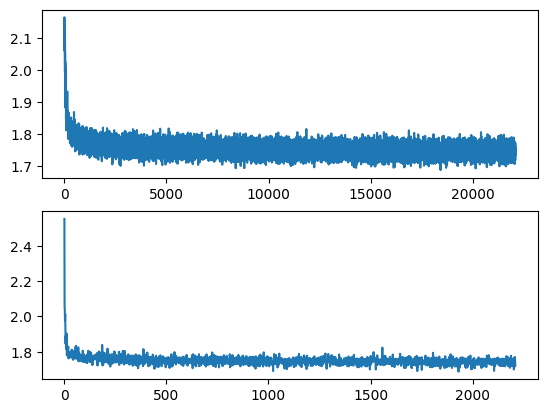

In [10]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)

x = list(range(1, len(train_losses) + 1))
axs[0].plot(x, train_losses)


x = list(range(1, len(validation_losses) + 1))
axs[1].plot(x, validation_losses)
plt.show()

# Saving the model

As long as we are carrying out the same experiment we should be able to save and load the model.
This saves a lot of time and allows us to restart from where we left off the previous time.

In [11]:
t.save(
    model.state_dict(),
    f"/home/andreacacioli/Documents/github/MachineLearning/Anime Recommender System (Knime)/models/{get_unique_experiment_name()}_epoch-{epoch}.pt",
)

# Testing the model

We are going to calculate some metrics on the test set:

- First, we are going to calculate the loss on the test set
- Secondly, we consider the most likely value of the model to be the predicted value
- Then, we are going to perform a sampling from the tensor and get it as a prediction

In [ ]:
from sklearn.metrics import classification_report


test_losses = []
y_true = []
y_pred_map = []
y_pred_sampled = []
y_scores = []

with t.no_grad():
    model.eval()
    for _, features, ge, target in tqdm(test_dataloader):
        loss, logits = run_step(model, loss_fn, features, ge, target)
        loss = loss.item()
        test_losses.append(loss)

        target = target.long().squeeze().tolist()
        y_true = y_true + target

        # Get likeliest value for each element of the batch
        likeliest = t.argmax(logits, dim=1)
        likeliest = likeliest + t.ones(likeliest.shape).to(
            device
        )  # Going from [0, 9] back to [1 - 10]
        y_pred_map = y_pred_map + likeliest.squeeze().tolist()

        # Get top_k values
        logits = t.nn.functional.softmax(logits, dim=1)
        y_scores += logits.tolist()
        sampled = t.multinomial(logits, 1)
        sampled = sampled + t.ones(sampled.shape).to(
            device
        )  # Going from [0, 9] back to [1 - 10]
        sampled = sampled.squeeze().tolist()
        y_pred_sampled = y_pred_sampled + sampled


print(f"Average test loss: {sum(test_losses) / len(test_losses)}")
print(f"-------------------------")
print(f"Maximum A Posteriori Probability")
print(classification_report(y_true, y_pred_map))
print(f"-------------------------")
print(f"Results sampling from the model")
print(classification_report(y_true, y_pred_sampled))

100%|██████████| 2761/2761 [11:41<00:00,  3.94it/s]


Average test loss: 1.7416792466389188
-------------------------
Maximum A Posteriori Probability


/home/andreacacioli/miniconda3/envs/experiments/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/andreacacioli/miniconda3/envs/experiments/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/andreacacioli/miniconda3/envs/experiments/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

              precision    recall  f1-score   support

           1       0.33      0.13      0.19     29141
           2       0.00      0.00      0.00     36762
           3       0.00      0.00      0.00     65022
           4       0.00      0.00      0.00    138175
           5       0.21      0.05      0.08    328783
           6       0.24      0.08      0.12    664364
           7       0.29      0.51      0.37   1307516
           8       0.31      0.49      0.38   1448489
           9       0.31      0.21      0.25    970337
          10       0.46      0.07      0.12    664870

    accuracy                           0.30   5653459
   macro avg       0.22      0.15      0.15   5653459
weighted avg       0.30      0.30      0.26   5653459

-------------------------
Results sampling from the model
              precision    recall  f1-score   support

           1       0.06      0.08      0.07     29141
           2       0.03      0.03      0.03     36762
           3       0

# Further Testing

Plotting the ROC plot we can see how the model is deviating from the pure chance.

Besides, we compute the micro-average AUC to see how the model is performing.

The **micro-average is preferable** in this case because the classes are not equally distributed.

Lastly, we compute the top@K Accuracy because we want to count how many times the rating appears in the top $k$ ratings predicted by the model.

One Hot encoded the test set: (5653459, 10)
One Hot Example #0: [0 0 0 0 0 0 0 0 0 1]

Logits given by the model: (5653459, 10)
Logits of Example #0: [0.0011011  0.00132204 0.00190077 0.00402346 0.01527424 0.02977295
 0.10451847 0.21329387 0.33122754 0.29756555]
Micro-averaged One-vs-Rest ROC AUC score: 0.81
TOP - K accuracy score: 0.723191058783658


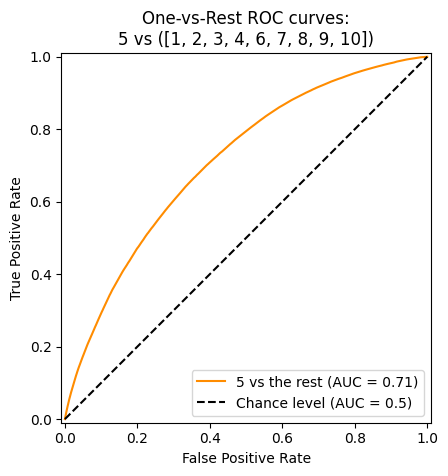

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, top_k_accuracy_score
from sklearn.preprocessing import LabelBinarizer
import numpy as np
from sklearn.metrics import roc_auc_score

rating_of_interest = 5
assert 0 < rating_of_interest <= 10, "The rating should be in range [1 - 10]"

label_binarizer = LabelBinarizer().fit(y_true) # One Hot encoding (sklearn style) 
y_one_hot = label_binarizer.transform(y_true) # Label binarizer takes care of the fact that y_true has range [1-10] while logits at position i contain the probability of the rating i + 1

logits = np.array(y_scores).squeeze()


print(f"One Hot encoded the test set: {y_one_hot.shape}")
print(f"One Hot Example #0: {y_one_hot[0]}")
print()
print(f"Logits given by the model: {logits.shape}")
print(f"Logits of Example #0: {logits[0]}")



# Plotting the ROC plot
display = RocCurveDisplay.from_predictions(
    y_one_hot[:, rating_of_interest - 1],
    logits[:, rating_of_interest - 1],
    name=f"{rating_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"One-vs-Rest ROC curves:\n{rating_of_interest} vs ({[i for i in range(1, 11) if i != rating_of_interest]})",
)

# Calculating AUC with micro average
micro_roc_auc_ovr = roc_auc_score(
    y_one_hot,
    logits,
    multi_class="ovr",
    average="micro",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score: {micro_roc_auc_ovr:.2f}")


#Calculating the top k accuracy of the model
K = 3
tk_acc = top_k_accuracy_score(y_true, logits, k=K)
print(f"TOP - K accuracy score: {tk_acc}")
